#Format Data for Experiment in ABM environment

In [1]:
#Import Packages
#Needed for moving to output
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as pl
import itertools
from collections import Counter
import pickle

from vivarium.library.units import units, remove_units
from tumor_tcell.library.phylogeny import get_phylogeny
from tumor_tcell.experiments.main import plots_suite

Loading chipmunk for Linux (64bit) [/mnt/c/Users/akoya-stanford/Python_Code/tumor-tcell/vivarium_env/lib/python3.8/site-packages/pymunk/libchipmunk.so]


In [2]:
#Read in the data from parent directory
analysis_dir = '/mnt/c/Users/akoya-stanford/Python_Code/tumor-tcell/out/analysis/'
experiment_id = 'tumor_tcell_20210415.165209/'
experiment_dir = analysis_dir+experiment_id
os.chdir(experiment_dir)
os.getcwd()

'/mnt/c/Users/akoya-stanford/Python_Code/tumor-tcell/out/analysis/tumor_tcell_20210415.165209'

In [3]:
file_to_read = open("data_export.pkl", "rb")
data = pickle.load(file_to_read)
data

{0.0: {'agents': {'tcell_0': {'boundary': {'diameter': 7.5,
     'velocity': 10.0,
     'exchange': {},
     'external': {'IFNg': 0.0},
     'location': [29.700695344117868, 15.734868045097201]},
    'internal': {'cell_state': 'PD1p'},
    'neighbors': {'present': {'TCR': 50000},
     'accept': {},
     'transfer': {'cytotoxic_packets': 0.0}}},
   'tcell_1': {'boundary': {'diameter': 7.5,
     'velocity': 10.0,
     'exchange': {},
     'external': {'IFNg': 0.0},
     'location': [21.15733761002662, 17.12100003120723]},
    'internal': {'cell_state': 'PD1n'},
    'neighbors': {'present': {'TCR': 50000},
     'accept': {},
     'transfer': {'cytotoxic_packets': 0.0}}},
   'tcell_2': {'boundary': {'diameter': 7.5,
     'velocity': 10.0,
     'exchange': {},
     'external': {'IFNg': 0.0},
     'location': [28.901564380051088, 28.887399376242758]},
    'internal': {'cell_state': 'PD1n'},
    'neighbors': {'present': {'TCR': 50000},
     'accept': {},
     'transfer': {'cytotoxic_packets':

In [4]:
# #Plot the data using tumor-tcell experiment notebook and save in current directory
# bounds = [75,75]
figures_out_dir = experiment_dir + 'figures'
os.makedirs(figures_out_dir, exist_ok=True)
# fig1, fig2, fig3 = plots_suite(data, out_dir = figures_out_dir, bounds=[b*units.um for b in bounds])

#Convert ABM data output to pandas dataframe format

In [5]:
#Convert to initial dataframe
df_data = pd.DataFrame(data)


#Extract agents from the data
df_copy = df_data.copy()
df_agents = df_copy.iloc[0,:]
agents_dict = df_agents.to_dict()

#reformat the dictionary into mulitiindexed dataframe
reform_agents = {(level1_key, level2_key): values
          for level1_key, level2_dict in agents_dict.items()
          for level2_key, values in level2_dict.items()
          }
df_agents_exp1 = pd.DataFrame(reform_agents)
df_agents_multi = df_agents_exp1.T
names=['time', 'cell']
df_agents_multi.index.set_names(names, inplace=True)


#Subset only T cells from all agents
df_tcell_agents = df_agents_multi.iloc[df_agents_multi.index.get_level_values('cell').str.contains('tcell'), :]


#Subset categories and recombine in T cells
df_tcell_trans = df_tcell_agents.T
tcell_categories = []

#Extract each feature - boundary, internal, neighbors
for category in df_tcell_trans.index.values:
  df_boundary_sub = df_tcell_trans.loc[category,:]
  tcell_boundary_dict = df_boundary_sub.to_dict()
  df_boundary_sub2 = pd.DataFrame(tcell_boundary_dict)
  tcell_categories.append(df_boundary_sub2.T)

#concatenate dataframes
tcell_data = pd.concat(tcell_categories, axis=1)


#reformat T cell data for plotting
tcell_data['IFNg'] = tcell_data['external'].apply(lambda x: x.get('IFNg'))
tcell_data['transferable_cytotoxic_packets'] = tcell_data['transfer'].apply(lambda x: x.get('cytotoxic_packets'))
tcell_data['TCR'] = tcell_data['present'].apply(lambda x: x.get('TCR'))
tcell_data['X'] = tcell_data['location'].apply(lambda x: x[0])
tcell_data['Y'] = tcell_data['location'].apply(lambda x: x[1])

#Only select columns of interest
tcell_columns = ['cell_state', 'IFNg', 'TCR', 'velocity', 'transferable_cytotoxic_packets', 'X', 'Y']
tcell_data_form = tcell_data[tcell_columns]
tcell_data_form.index.set_names(names, inplace=True)

tcell_data_form

cell_state      IFNg    TCR velocity  \
time    cell                                               
0.0     tcell_0           PD1p  0.000000  50000       10   
        tcell_1           PD1n  0.000000  50000       10   
        tcell_2           PD1n  0.000000  50000       10   
60.0    tcell_0           PD1p  0.997436  50000        0   
        tcell_1           PD1n  0.997436  50000        0   
...                        ...       ...    ...      ...   
50400.0 tcell_1ABB        PD1n  0.000027  50000        0   
        tcell_2AA         PD1n  0.000027  50000        0   
        tcell_2AB         PD1n  0.000027  50000        0   
        tcell_1ABAA       PD1n  0.000027  50000        0   
        tcell_1ABAB       PD1n  0.000027  50000        0   

                     transferable_cytotoxic_packets          X          Y  
time    cell                                                               
0.0     tcell_0                                 0.0  29.700695  15.734868  
        tcell_1                                 0.0  21.157338  17.121000  
        tcell_2                                 0.0  28.901564  28.887399  
60.0    tcell_0                                 0.0  26.350000   5.374918  
        tcell_1                                 0.0  18.540111   5.463853  
...                                             ...        ...        ...  
50400.0 tcell_1ABB                              0.0  29.491339  15.681964  
        tcell_2AA                               0.0  23.189676  26.350000  
        tcell_2AB                               0.0  27.548440  22.143389  
        tcell_1ABAA                             0.0  27.885164   3.075666  
        tcell_1ABAB                             0.0  27.644419   8.493868  

[3831 rows x 7 columns]

In [6]:
####Extract death log statistics
df_death = df_copy.iloc[1,:]
death_dict = df_death.to_dict()

#reformat the dictionary into mulitiindexed dataframe
reform_death = {(level1_key, level2_key): values
          for level1_key, level2_dict in death_dict.items()
          for level2_key, values in level2_dict.items()}

#Make dataframe
df_death_exp1 = pd.DataFrame(reform_death)
df_death_multi = df_death_exp1.T
names=['time', 'cell']
df_death_multi.index.set_names(names, inplace=True)
df_death_multi.columns = ['time', 'death']

#subset only where death is not equal to false
df_death_sub = df_death_multi[~(df_death_multi['death'] == False)]

#Only get the final log of the death than contains all the death information
df_last_death = df_death_sub.loc[df_death_sub.index.levels[0][-1]]

#Subset only T cells from all agents
df_tcell_death = df_last_death.iloc[df_last_death.index.get_level_values('cell').str.contains('tcell'), :]
df_tumor_death = df_last_death.iloc[df_last_death.index.get_level_values('cell').str.contains('tumor'), :]



##Do for T cells
#sort deaths by time
df_tcell_death.sort_values(by=['time'], inplace=True)

#Get different death groupings and count total over time
death_types_list = list(df_tcell_death['death'].unique())
for death_type in death_types_list:
  df_tcell_death[death_type] = df_tcell_death['death'].apply(lambda x: 1 if x==death_type else 0)
  df_tcell_death['total_'+str(death_type)] = df_tcell_death[death_type].cumsum()

#get total death count over time
total_col_t = [col for col in df_tcell_death.columns if 'total' in col]
df_tcell_death['total_death'] = df_tcell_death[total_col_t].sum(axis = 1)


##Do for Tumors
#sort deaths by time
df_tumor_death.sort_values(by=['time'], inplace=True)

#Get different death groupings and count total over time
death_types_list = list(df_tumor_death['death'].unique())
for death_type in death_types_list:
  df_tumor_death[death_type] = df_tumor_death['death'].apply(lambda x: 1 if x==death_type else 0)
  df_tumor_death['total_'+str(death_type)] = df_tumor_death[death_type].cumsum()

#get total death count over time
total_col = [col for col in df_tumor_death.columns if 'total' in col]
df_tumor_death['total_death'] = df_tumor_death[total_col].sum(axis = 1)

df_tumor_death;

<ipython-input-6-6c37bd279b4c>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tumor_death.sort_values(by=['time'], inplace=True)


In [7]:
#Subset only Tumor cells from all agents
df_tumor_agents = df_agents_multi.iloc[df_agents_multi.index.get_level_values('cell').str.contains('tumor'), :]


#Subset categories and recombine in Tumor cells
df_tumor_trans = df_tumor_agents.T
tumor_categories = []

#Extract each feature - boundary, internal, neighbors
for category in df_tumor_trans.index.values:
  df_boundary_sub = df_tumor_trans.loc[category,:]
  tumor_boundary_dict = df_boundary_sub.to_dict()
  df_boundary_sub2 = pd.DataFrame(tumor_boundary_dict)
  tumor_categories.append(df_boundary_sub2.T)

#concatenate dataframes
tumor_data = pd.concat(tumor_categories, axis=1)
tumor_data;

#reformat Tumor cell data for plotting
tumor_data['IFNg'] = tumor_data['external'].apply(lambda x: x.get('IFNg'))
tumor_data['cytotoxic_packets'] = tumor_data['receive'].apply(lambda x: x.get('cytotoxic_packets'))
tumor_data['TCR_neighbor'] = tumor_data['accept'].apply(lambda x: x.get('TCR'))
tumor_data['X'] = tumor_data['location'].apply(lambda x: x[0])
tumor_data['Y'] = tumor_data['location'].apply(lambda x: x[1])
tumor_data.columns

#Only select columns of interest
tumor_columns = ['cell_state', 'IFNg', 'TCR_neighbor', 'cytotoxic_packets', 'X', 'Y']
tumor_data_form = tumor_data[tumor_columns]
tumor_data_form.index.set_names(names, inplace=True)

tumor_data_form

cell_state      IFNg  TCR_neighbor  cytotoxic_packets  \
time    cell                                                            
0.0     tumor_0      PDL1n  0.000000           0.0                0.0   
        tumor_1      PDL1n  0.000000           0.0                0.0   
        tumor_2      PDL1n  0.000000           0.0                0.0   
60.0    tumor_0      PDL1n  0.997436       50000.0                0.0   
        tumor_1      PDL1n  0.997436           0.0                0.0   
...                    ...       ...           ...                ...   
50340.0 tumor_1      PDL1n  0.000027       50000.0                0.0   
        tumor_2      PDL1n  0.000027      350000.0                0.0   
50400.0 tumor_0      PDL1n  0.000027       50000.0                0.0   
        tumor_1      PDL1n  0.000027       50000.0                0.0   
        tumor_2      PDL1n  0.000027      350000.0                0.0   

                         X          Y  
time    cell                           
0.0     tumor_0   8.631013   6.156635  
        tumor_1  16.361503  27.545959  
        tumor_2  22.529430  20.177427  
60.0    tumor_0   7.559499   7.400002  
        tumor_1   9.274297  22.600000  
...                    ...        ...  
50340.0 tumor_1   6.491810  23.005494  
        tumor_2  19.140104  15.091646  
50400.0 tumor_0   6.755554   7.305888  
        tumor_1   6.351297  22.984142  
        tumor_2  19.001250  15.617706  

[2523 rows x 6 columns]

In [8]:
#phylogeny plot?

#Plotting the Data from the Experiment

In [9]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

pl.rc('font', size=SMALL_SIZE)          # controls default text sizes
pl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
pl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
pl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [10]:
os.chdir(figures_out_dir)

DataError: No numeric types to aggregate

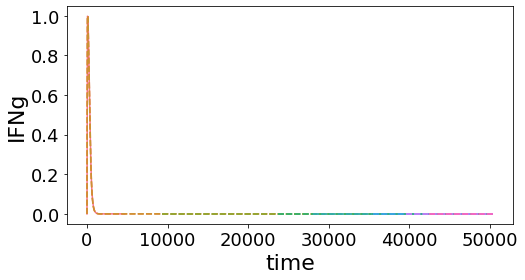

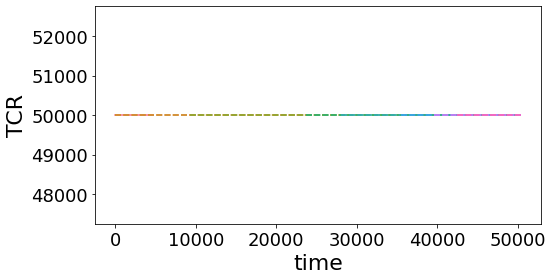

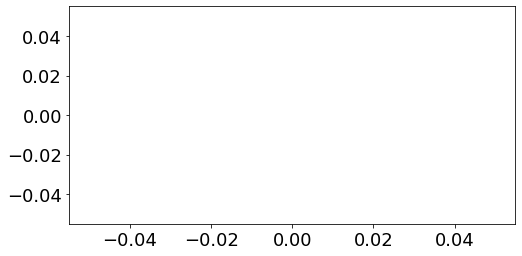

In [11]:
#reset index for plotting
tcell_plot = tcell_data_form.reset_index()
# plot the data to analyze
plotting_columns = ['IFNg', 'TCR', 'velocity', 'transferable_cytotoxic_packets']
for column in plotting_columns:
    pl.figure(figsize=(8, 4))
    column_1 = sns.lineplot(data=tcell_plot, x="time", y=column, style = 'cell_state', hue="cell", legend = None)
    pl.savefig(column+'_t_cell.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
#How to extract individual T cells
df_divide_T = tcell_plot.drop_duplicates('cell', keep='first')

#Get unique agent IDs
unique_T_cell = list(df_divide_T.cell.unique())

#run phylogeny function
phylogeny_T = get_phylogeny(unique_T_cell)

# get initial ancestors, daughters, and mothers
daughters_T = list(phylogeny_T.values())
daughters_T = set([item for sublist in daughters_T for item in sublist])
descendents_T = list(daughters_T)
mothers_T = set(list(phylogeny_T.keys()))
ancestors_T = list(mothers_T - daughters_T)
ancestors_T;

In [ ]:
#Time for plotting cell divisions
div_list_T = []
for cell in descendents_T:
  div = df_divide_T[df_divide_T["cell"] == cell]['time'].min()
  div_list_T.append(div)

#get unique counts from the list
div_counts_T = Counter(div_list_T)
divide_time_T = pd.DataFrame.from_dict(div_counts_T, orient='index').reset_index()

#convert to dataframe
column_names = ['time', 'counts']
divide_time_T.columns = column_names

#divide counts by 2 because each daughter and original cell is counted twice
divide_time_T['counts'] = divide_time_T['counts'] / 2

#add 0, 0 initial point
divide_time_T.loc[-1] = [0, 0]
divide_time_T.index = divide_time_T.index + 1  # shifting index
divide_time_T = divide_time_T.sort_values(by = 'time') 

#accumulate the counts as progresses
divide_time_T['total_division'] = divide_time_T.counts.cumsum()

pl.figure(figsize=(8, 4))
div_cell_T = sns.lineplot(data=divide_time_T, x="time", y='total_division')

pl.title("# of divisions")
pl.savefig('tcell_division.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
#Plot total cells and see how changing over time
total_tcell = tcell_plot.groupby('time')['cell'].nunique().reset_index()
tcell_state = tcell_plot.groupby(['time','cell_state'])['cell'].nunique().reset_index()
total_PD1n = tcell_state.loc[tcell_state['cell_state']=='PD1n']
total_PD1p = tcell_state.loc[tcell_state['cell_state']=='PD1p']

pl.figure(figsize=(8, 4))
ttl_tcell = sns.lineplot(data=total_tcell, x="time", y='cell', label = 'total')
ttl_PD1n = sns.lineplot(data=total_PD1n, x="time", y='cell', label = 'PD1n')
ttl_PD1p = sns.lineplot(data=total_PD1p, x="time", y='cell', label = 'PD1p')

pl.title("Total T Cells")
pl.legend(title="Cell type")
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.savefig('tcell_total.png', format='png', bbox_inches='tight', dpi=300)

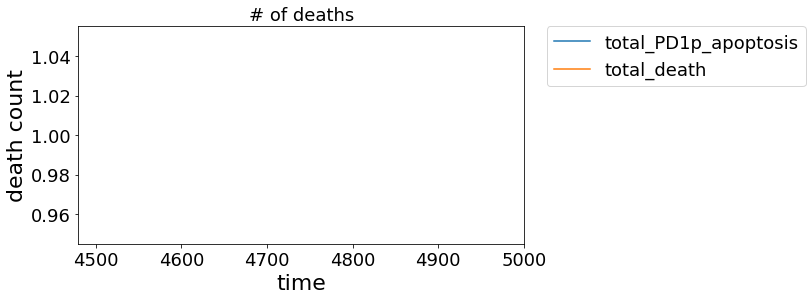

In [12]:
#Plot total number of deaths and type
total_col_t = [col for col in df_tcell_death.columns if 'total' in col]
pl.figure(figsize=(8, 4))
death_plot_t = pd.melt(df_tcell_death, id_vars= ['death', 'time'], value_vars= total_col_t)
death_plot_t.rename(columns={'variable':'death type', 'value' : 'death count'}, inplace=True)
death_cell_T = sns.lineplot(data=death_plot_t, x="time", y='death count', hue='death type')
pl.title("# of deaths")
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.savefig('tcell_death.png', format='png', bbox_inches='tight', dpi=300)

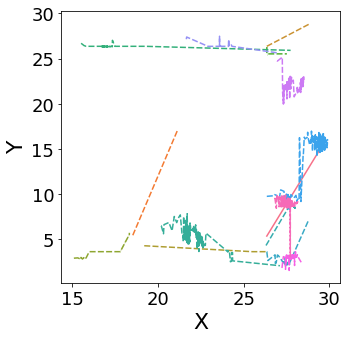

In [22]:
#Spatial
pl.figure(figsize=(5, 5))
XandY = sns.lineplot(data=tcell_plot, x="X", y="Y", style = 'cell_state', hue="cell", legend = None)

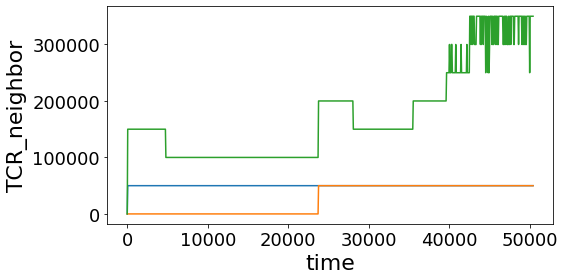

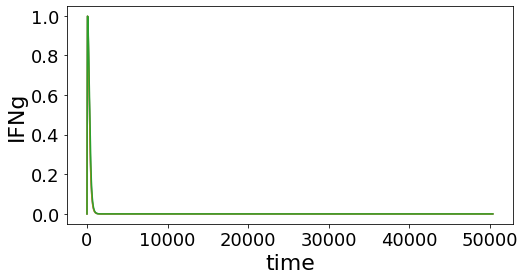

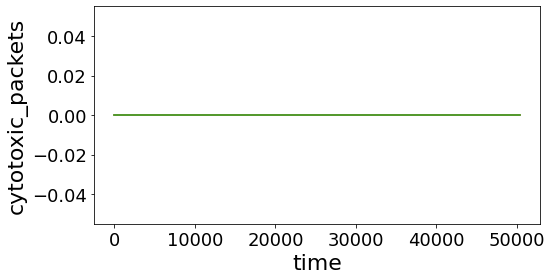

In [14]:
#reset index for plotting
tumor_plot = tumor_data_form.reset_index()

# plot the data to analyze
plotting_columns = ['TCR_neighbor', 'IFNg', 'cytotoxic_packets']
for column in plotting_columns:
    pl.figure(figsize=(8, 4))
    column_1 = sns.lineplot(data=tumor_plot, x="time", y=column, style = 'cell_state', hue="cell", legend = None)
    pl.savefig(column+'_tumor.png', format='png', bbox_inches='tight', dpi=300)

In [15]:
#How to extract individual tumor cells
df_divide_tumor = tumor_plot.drop_duplicates('cell', keep='first')

#Get unique agent IDs
unique_tumor_cell = list(df_divide_tumor.cell.unique())

#run phylogeny function
phylogeny_tumor = get_phylogeny(unique_tumor_cell)

# get initial ancestors, daughters, and mothers
daughters_tumor = list(phylogeny_tumor.values())
daughters_tumor = set([item for sublist in daughters_tumor for item in sublist])
descendents_tumor = list(daughters_tumor)
mothers_tumor = set(list(phylogeny_tumor.keys()))
ancestors_tumor = list(mothers_tumor - daughters_tumor)
descendents_tumor;

In [16]:
#Time for plotting cell divisions
div_list_tumor = []
for cell in descendents_tumor:
  div = df_divide_tumor[df_divide_tumor["cell"] == cell]['time'].min()
  div_list_tumor.append(div)

#get unique counts from the list
div_counts_tumor = Counter(div_list_tumor)
divide_time_tumor = pd.DataFrame.from_dict(div_counts_tumor, orient='index').reset_index()

#convert to dataframe
column_names = ['time', 'counts']
divide_time_tumor.columns = column_names

#divide counts by 2 because each daughter and original cell is counted twice
divide_time_tumor['counts'] = divide_time_tumor['counts'] / 2

#add 0, 0 initial point
divide_time_tumor.loc[-1] = [0, 0]
divide_time_tumor.index = divide_time_tumor.index + 1  # shifting index
divide_time_tumor = divide_time_tumor.sort_values(by = 'time') 

#accumulate the counts as progresses
divide_time_tumor['total_division'] = divide_time_tumor.counts.cumsum()

pl.figure(figsize=(8, 4))
div_cell_tumor = sns.lineplot(data=divide_time_tumor, x="time", y='total_division')

pl.title("# of divisions")
pl.savefig('tumor_division.png', format='png', bbox_inches='tight', dpi=300)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

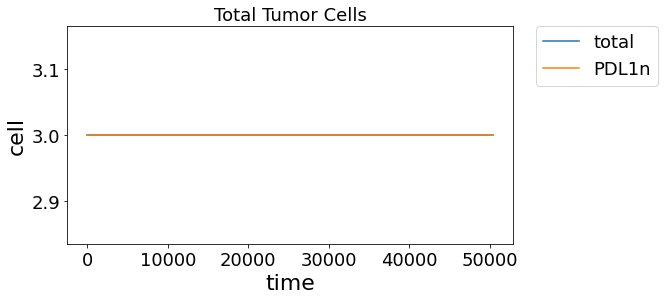

In [17]:
#Plot total cells and see how changing over time
total_tumor = tumor_plot.groupby('time')['cell'].nunique().reset_index()
tumor_state = tumor_plot.groupby(['time','cell_state'])['cell'].nunique().reset_index()
total_PDL1n = tumor_state.loc[tumor_state['cell_state']=='PDL1n']
total_PDL1p = tumor_state.loc[tumor_state['cell_state']=='PDL1p']

pl.figure(figsize=(8, 4))
ttl_tumorcell = sns.lineplot(data=total_tumor, x="time", y='cell', label = 'total')
ttl_PDL1n = sns.lineplot(data=total_PDL1n, x="time", y='cell', label = 'PDL1n')
ttl_PDL1p = sns.lineplot(data=total_PDL1p, x="time", y='cell', label = 'PDL1p')

pl.title("Total Tumor Cells")
pl.legend(title="Cell type")
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.savefig('tumor_total.png', format='png', bbox_inches='tight', dpi=300)

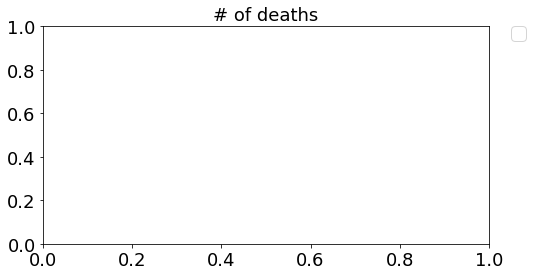

In [18]:
#Plot total number of deaths and type
total_col = [col for col in df_tumor_death.columns if 'total' in col]
pl.figure(figsize=(8, 4))
death_plot = pd.melt(df_tumor_death, id_vars= ['death', 'time'], value_vars= total_col)
death_plot.rename(columns={'variable':'death type', 'value' : 'death count'}, inplace=True)
death_cell = sns.lineplot(data=death_plot, x="time", y='death count', hue='death type')
pl.title("# of deaths")
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.savefig('tumor_death.png', format='png', bbox_inches='tight', dpi=300)

#Spatial Widget

In [26]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# %matplotlib inline

# def plot_func(time):
#     x = tcell_plot[tcell_plot['time']<=time]['X']
#     y = tcell_plot[tcell_plot['time']<=time]['Y']
#     data_t = tcell_plot[tcell_plot['time']<=time]
#     xandy = sns.lineplot(data=data_t, x=x, y=y, hue = 'cell_state', style = 'cell', legend = None)
#     pl.show()

# interact(plot_func, time = widgets.FloatSlider(value=0,
#                                                min=0,
#                                                max=10000,
#                                                step=60))

ModuleNotFoundError: No module named 'ipywidgets'

In [19]:
tcell_plot.X.min()

15.107203502120036

In [20]:
tcell_plot.Y.min()

1.5747838844981135

In [ ]:
#tcell_plot.to_csv(ROOT + '/My Drive/Research/TNT/ABM_CODEX/Scripts_Data/'+'tcell_neg_data.csv')

In [38]:
len(tcell_plot.time.unique())

841

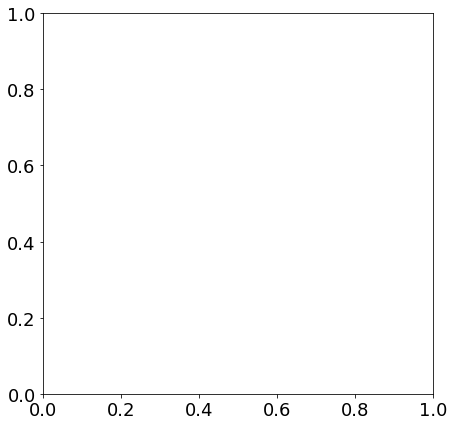

In [25]:
#Animated scatter plot trial
from matplotlib.animation import FuncAnimation
fig, ax = pl.subplots(figsize = (7, 7))

def animate(i):
    ax.cla()
    time1 = i * 60
    sns.scatterplot(x = 'X',
                    y = 'Y',
                    data = tcell_plot[tcell_plot.time == time1],
                    hue = 'cell_state',
                    ax = ax,
                    alpha = 0.7,)
    ax.set_title(f'Seconds {time1}')

ani = FuncAnimation(fig = fig, func = animate), frames = len(tcell_plot.time.unique()), interval = 60)
pl.show()
#ani.save('animation.mp4')

In [ ]:
#Or try this
fig, ax = pl.subplots()
scatters = []
for g,d in tips.groupby('smoker'):
    s = ax.scatter(x="X", y="Y", data=tcell_plot, label=g)
    scatters.append(s)
ax.legend(bbox_to_anchor=(1.,1.), loc=1)
txt = ax.text(0.1,0.9,'frame=0', transform=ax.transAxes)

def animate(i):
    for c in scatters:
        x = np.random.random(size=(50,1))*50
        y = np.random.random(size=(50,1))*10
        xy = np.hstack([x,y])
        c.set_offsets(xy)
    txt.set_text('frame={:d}'.format(i))
    return scatters+[txt]

ani = animation.FuncAnimation(fig, animate, frames=10, blit=True)